### Imports

In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

### Set Seed

In [2]:
SEED = 42

### Load Full Data

In [3]:
DATA_FOLDER_PATH = os.path.normpath(os.path.join("..", "data"))
medquad = pd.read_csv(os.path.join(DATA_FOLDER_PATH, "raw", "medquad.csv"))

In [4]:
medquad.head(5)

,question,answer,source,focus_area
0,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,NIHSeniorHealth,Glaucoma
1,What causes Glaucoma ?,"Nearly 2.7 million people have glaucoma, a lea...",NIHSeniorHealth,Glaucoma
2,What are the symptoms of Glaucoma ?,Symptoms of Glaucoma Glaucoma can develop in ...,NIHSeniorHealth,Glaucoma
3,What are the treatments for Glaucoma ?,"Although open-angle glaucoma cannot be cured, ...",NIHSeniorHealth,Glaucoma
4,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,NIHSeniorHealth,Glaucoma


In [5]:
print(f"Shape of full dataset: {medquad.shape}")

Shape of full dataset: (16412, 4)


### Using Subset of Data

We shall scope our project to only consider common focus areas. In other words, we will remove rows corresponding to focus areas which do not meet a minimum frequency count.

We also remove rows that have missing values in "question" and "answer".

In [6]:
def get_focus_area_counts(medquad_df):
    return medquad_df \
        .groupby("focus_area") \
        .count()[["question"]] \
        .reset_index() \
        .sort_values(by="question", ascending=False)

def find_common_focus_areas(medquad_df, min_question_count):
    counts_per_focus_area = get_focus_area_counts(medquad_df=medquad_df)
    common_focus_areas_with_counts = counts_per_focus_area[counts_per_focus_area["question"] >= min_question_count]
    
    return set(common_focus_areas_with_counts["focus_area"])

In [7]:
def remove_rows_and_handle_nan(medquad_df: pd.DataFrame, min_question_count):
    # Remove rows with missing questions / answer
    medquad_df = medquad_df.dropna(subset=["question", "answer"])

    # Impute missing focus area with "Others"
    medquad_df = medquad_df.fillna(
        {"focus_area": "Others"}
    )

    # Only consider focus areas with a minimum frequency
    medquad_df = medquad_df[
        medquad_df["focus_area"].isin(
            find_common_focus_areas(medquad_df, min_question_count)
        )
    ]

    return medquad_df

In [8]:
MIN_QUESTION_COUNT = 2

medquad_raw_df = remove_rows_and_handle_nan(medquad_df=medquad, min_question_count=MIN_QUESTION_COUNT)
print(f"Shape after removing rows: {medquad_raw_df.shape}")

Shape after removing rows: (14075, 4)


### Train-Test Split

We use stratified split to preserve the composition of focus areas, as much as possible.

In [9]:
# Split data
TEST_SIZE = 0.2

medquad_raw_df_train, medquad_raw_df_test = train_test_split(
    medquad_raw_df,
    test_size=TEST_SIZE,
    random_state=SEED,
    stratify=medquad_raw_df["focus_area"]
)

In [10]:
print(f"Shape of train split: {medquad_raw_df_train.shape}")
print(f"Shape of test split: {medquad_raw_df_test.shape}")

Shape of train split: (11260, 4)
Shape of test split: (2815, 4)


### Data Processing

- Remove abnormally long answers. Our base model of choice has a context window of 2048 tokens. Hence we need to have the model output an answer that is within this limited context window (with some allowance for the question length).

In [11]:
def process_data(medquad_df, max_answer_length):
    # Remove rows with abnormally long answers (below a certain cutoff)
    medquad_df["answer_length"] = medquad_df["answer"].apply(lambda ans: len(ans.split()))
    medquad_df = medquad_df[medquad_df["answer_length"] <= max_answer_length]

    # Drop answer length columns
    medquad_df = medquad_df.drop(["answer_length"], axis=1)

    return medquad_df

In [12]:
MAX_ANSWER_LENGTH = 2000   # In terms of tokens

medquad_df_train = process_data(medquad_raw_df_train, MAX_ANSWER_LENGTH)
medquad_df_test = process_data(medquad_raw_df_test, MAX_ANSWER_LENGTH)

In [13]:
print(f"Final shape after processing train: {medquad_df_train.shape}")
print(f"Final shape after processing test: {medquad_df_test.shape}")

Final shape after processing train: (11217, 4)
Final shape after processing test: (2801, 4)


In [14]:
medquad_df_train.head(5)

,question,answer,source,focus_area
13765,"What is (are) methemoglobinemia, beta-globin t...","Methemoglobinemia, beta-globin type is a condi...",GHR,"methemoglobinemia, beta-globin type"
12548,Is multiple sulfatase deficiency inherited ?,This condition is inherited in an autosomal re...,GHR,multiple sulfatase deficiency
9817,What are the genetic changes related to pachyo...,"Mutations in several genes, including KRT6A, K...",GHR,pachyonychia congenita
5081,How to diagnose Tetra-amelia syndrome ?,How is tetra-amelia syndrome diagnosed? The di...,GARD,Tetra-amelia syndrome
13568,Is arginine:glycine amidinotransferase deficie...,This condition is inherited in an autosomal re...,GHR,arginine:glycine amidinotransferase deficiency


In [15]:
medquad_df_test.head(5)

,question,answer,source,focus_area
16287,What is (are) Zollinger-Ellison Syndrome ?,"The stomach, duodenum, and pancreas are digest...",NIDDK,Zollinger-Ellison Syndrome
13713,"Is GM2-gangliosidosis, AB variant inherited ?",This condition is inherited in an autosomal re...,GHR,"GM2-gangliosidosis, AB variant"
1356,How to diagnose Childhood Hodgkin Lymphoma ?,Tests that examine the lymph system are used t...,CancerGov,Childhood Hodgkin Lymphoma
3467,How to diagnose Gardner-Diamond syndrome ?,How is Gardner-Diamond syndrome diagnosed? The...,GARD,Gardner-Diamond syndrome
9569,what research (or clinical trials) is being do...,Researchers continue to search for the defecti...,NINDS,Neuroaxonal dystrophy


### Checking Processed Data

#### Check for NaNs

In [16]:
medquad_df_train.isna().sum()

question      0
answer        0
source        0
focus_area    0
dtype: int64

In [17]:
medquad_df_test.isna().sum()

question      0
answer        0
source        0
focus_area    0
dtype: int64

#### Check Focus Areas

Since some focus areas are rare, they may not be present in both the train and test set, even after the stratified split. At the very least, we can verify that all the focus areas in the test set are also present in the train set. This ensures that we do not evaluate the model on a focus area that it has not seen before.

In [18]:
# Check if the focus areas in the test set are also in the train set
focus_area_train = set(medquad_df_train["focus_area"])
focus_area_test = set(medquad_df_test["focus_area"])
focus_area_test.issubset(focus_area_train)

True

In [19]:
def plot_focus_area_counts(medquad_df_train, medquad_df_test, num_top_areas=20):
    # Select the most common classes in train
    counts_per_focus_area_train = get_focus_area_counts(medquad_df=medquad_df_train).head(num_top_areas)
    counts_per_focus_area_train["dataset"] = "train"

    # Select the classes in test, corresponding to those in train
    counts_per_focus_area_test = get_focus_area_counts(medquad_df=medquad_df_test)
    counts_per_focus_area_test = counts_per_focus_area_test[
        counts_per_focus_area_test["focus_area"].isin(counts_per_focus_area_train["focus_area"])
    ]
    counts_per_focus_area_test["dataset"] = "test"
    
    counts_per_focus_area = pd.concat(
        [counts_per_focus_area_train, counts_per_focus_area_test], axis=0, ignore_index=True
    )

    plt.figure(figsize=(15, 10))

    sns.barplot(
        data=counts_per_focus_area,
        x="focus_area",
        y="question",
        hue="dataset"
    )

    plt.xticks(rotation=45, ha="right")
    plt.title("Top Focus Areas by Frequency")
    plt.xlabel("Focus Area")
    plt.ylabel("Number of Samples")
    plt.show()

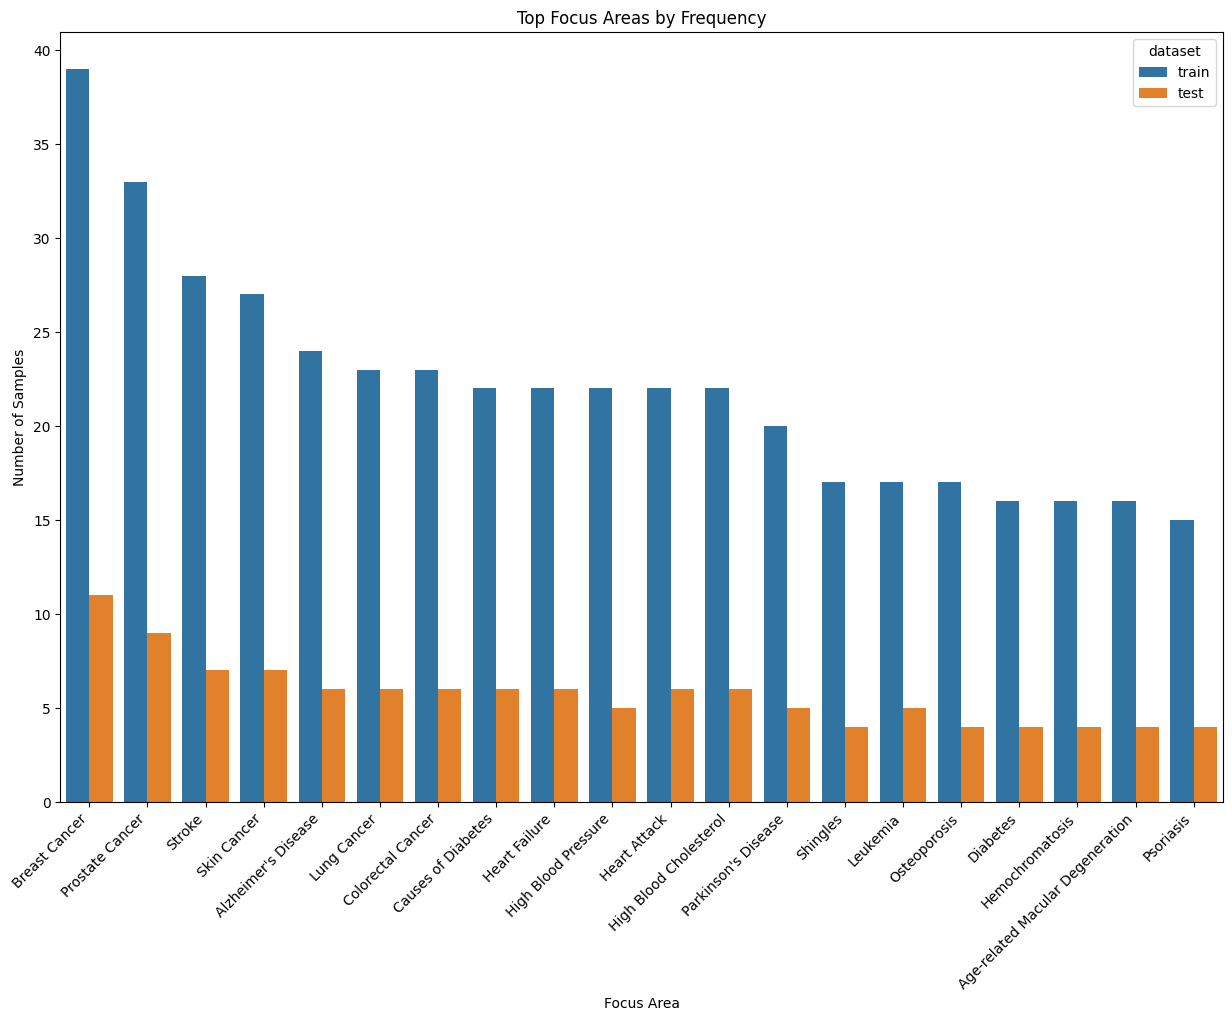

In [20]:
plot_focus_area_counts(
    medquad_df_train=medquad_df_train,
    medquad_df_test=medquad_df_test
)

#### Check Answer Length

In [21]:
def plot_answer_lengths(medquad_df):
    medquad_df = medquad_df.copy(deep=True)
    medquad_df["answer_length"] = medquad_df["answer"].apply(lambda x: len(x.split()))

    plt.figure(figsize=(15, 10))

    sns.histplot(
        data=medquad_df,
        x="answer_length",
        kde=True,
        bins=70
    )

    plt.title("Histogram of Answer Length")
    plt.xlabel("Answer Length")
    plt.show()

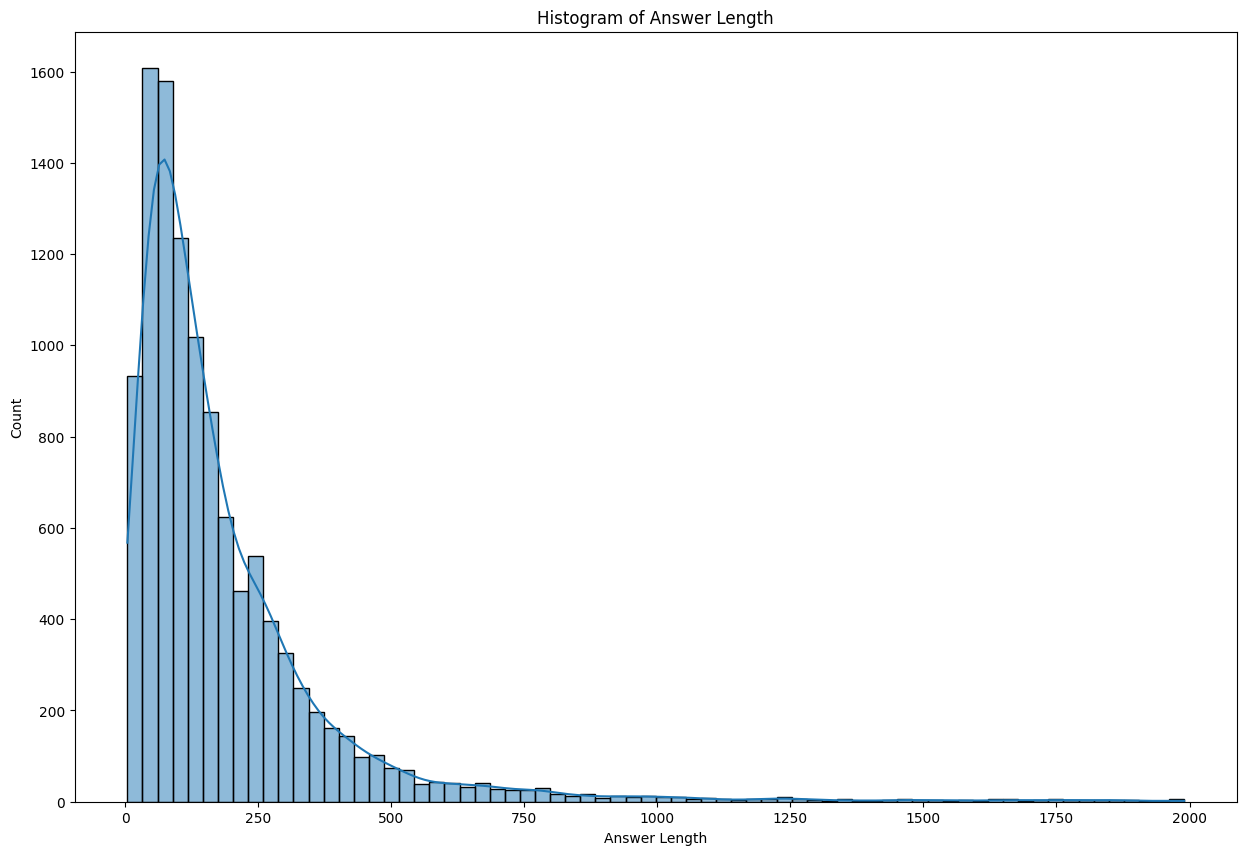

In [22]:
plot_answer_lengths(medquad_df=medquad_df_train)

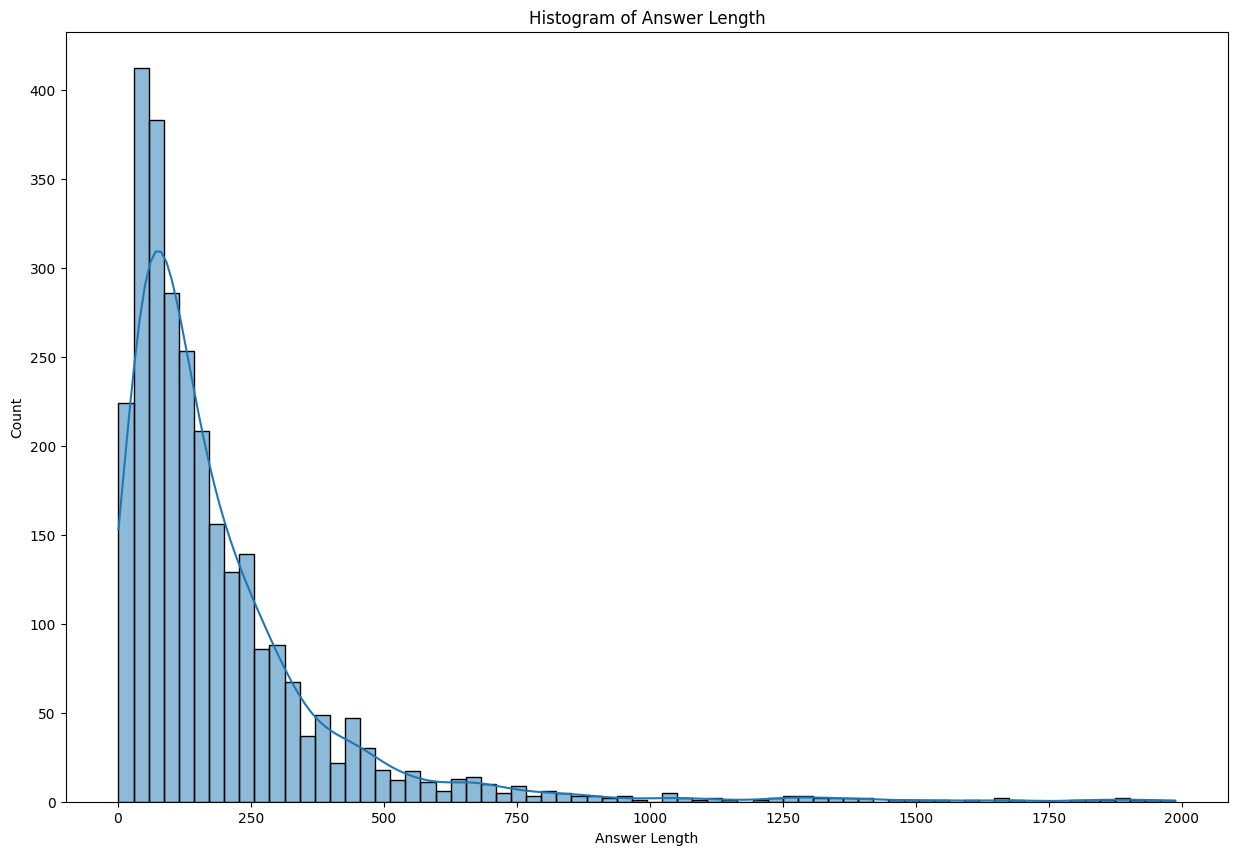

In [23]:
plot_answer_lengths(medquad_df=medquad_df_test)

### Save Processed Data

In [24]:
PROCESSED_DATA_PATH = os.path.join(DATA_FOLDER_PATH, "processed")
os.makedirs(PROCESSED_DATA_PATH, exist_ok=True)
medquad_df_train.to_csv(os.path.join(PROCESSED_DATA_PATH, "train.csv"), index=False)
medquad_df_test.to_csv(os.path.join(PROCESSED_DATA_PATH, "test.csv"), index=False)